Codebasics - Bag of N grams tutorial

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [9]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [10]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

In [11]:

corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [14]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

In [15]:
preprocess("Thor ate pizza")

'thor eat pizza'

In [13]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [16]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [17]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [18]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]])

In [19]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

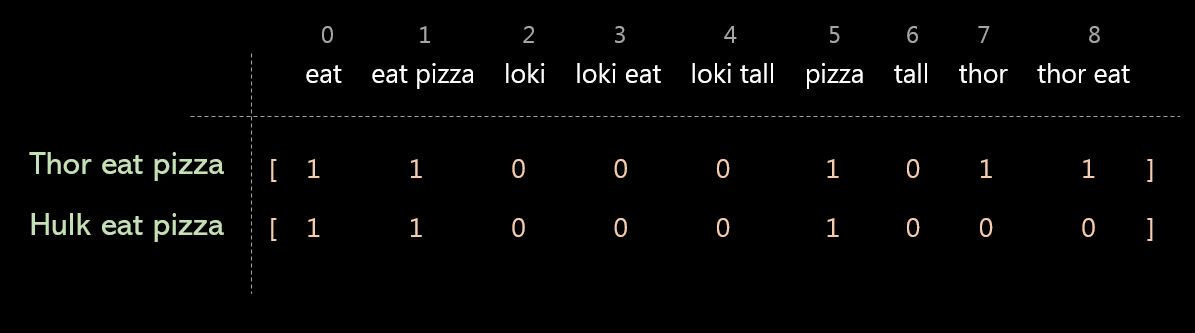

News Category Classification Problem

In [20]:
import pandas as pd

df = pd.read_json('https://raw.githubusercontent.com/codebasics/nlp-tutorials/main/11_bag_of_n_grams/news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [21]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

Handle class imbalance

In [22]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class

df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [23]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

Convert text category to a number

In [24]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map(target)

Build a model with original text (no pre processing)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [26]:
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [27]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [28]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))), #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [30]:
y_pred[:5]

array([0, 3, 3, 0, 2])

In [31]:
y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

Use 1-gram and bigrams

In [32]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



Use 1-gram to trigrams

In [33]:

#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



Use text pre-processing to remove stop words, punctuations and apply lemmatization

In [34]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 

In [35]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business Leaders remain Confident Face Reg...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


Build a model with pre processed text

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [37]:
print(X_train.shape)
X_train.head()

(4419,)


7589     ovulate woman prefer Images Penetration Images...
10442     scientist Discover Spooky Influence Baby Choices
8792     Olympic Race Walker step Propose Boyfriend Rio...
1733     Beloved Bipedal Bear name Pedals believe kill ...
2526       Elizabeth Smart give Birth Baby Girl Father say
Name: preprocessed_txt, dtype: object

In [38]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [39]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

In [40]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.82      0.87       277
           2       0.83      0.92      0.87       276
           3       0.90      0.81      0.85       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



Plot confusion matrix

In [44]:
y_test

3716     0
608      3
11172    3
1346     0
1356     2
        ..
12015    1
3484     1
10023    2
9471     1
7877     2
Name: category_num, Length: 1105, dtype: int64

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[243,   8,  17,   8],
       [ 10, 228,  29,  10],
       [ 15,   2, 253,   6],
       [ 36,   9,   7, 224]])

Text(95.72222222222221, 0.5, 'Truth')

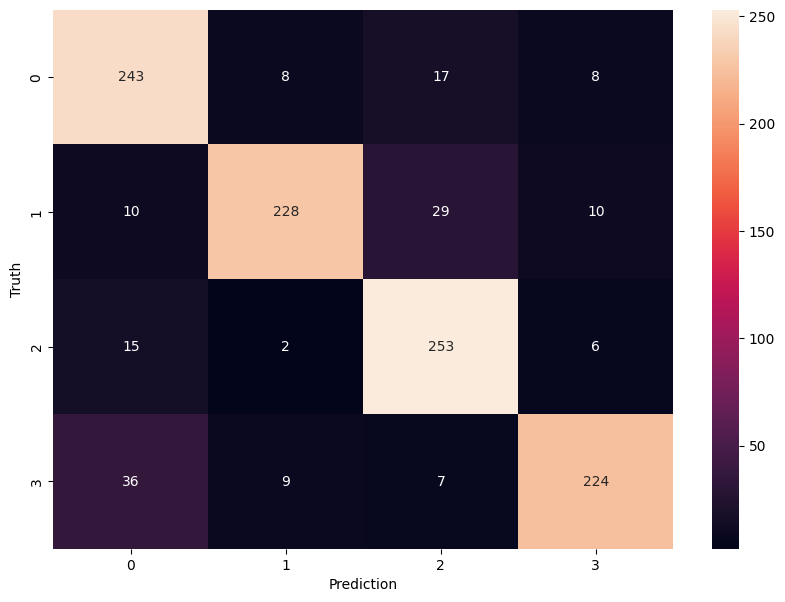

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')